## Airlines Analysis

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import dataset.
df = pd.read_csv('Resources/Airlines.csv')
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
df.count()

id             539383
Airline        539383
Flight         539383
AirportFrom    539383
AirportTo      539383
DayOfWeek      539383
Time           539383
Length         539383
Delay          539383
dtype: int64

### Data Cleaning

In [5]:
# Determine any missing values.
df.isnull().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [6]:
# Check for duplicates.
df.duplicated().sum()

0

In [7]:
# Check for data types.
df.dtypes

id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

In [8]:
df = df.drop('id', axis=1)

### Analyze for numeric variables.

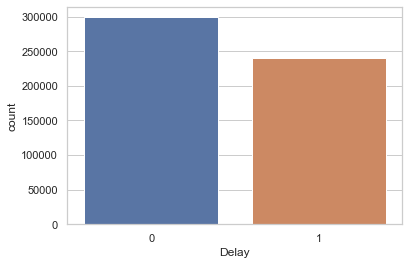

In [9]:
sns.countplot(x='Delay', data=df)
plt.show()

In [20]:
y = df[df.Delay==1]
n = df[df.Delay==0]
print(f'{round(y.Delay.count()/df.Delay.count()*100)}% of the flights are delay')
print(f'{round(n.Delay.count()/df.Delay.count()*100)}% of the flights are on time')

45% of the flights are delay
55% of the flights are on time


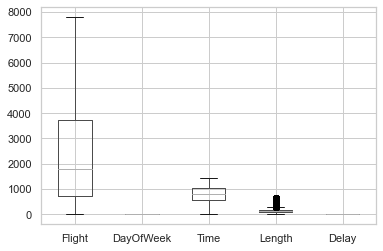

In [10]:
# Check for distribution.
df.boxplot()
plt.show()

#### Take a closer look at the distributions of DayOfWeek and Length.

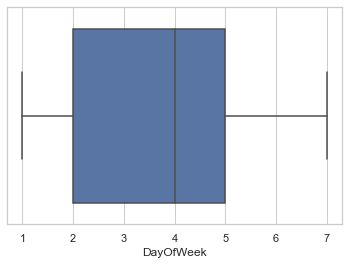

In [9]:
sns.boxplot('DayOfWeek', data=df)
plt.show()

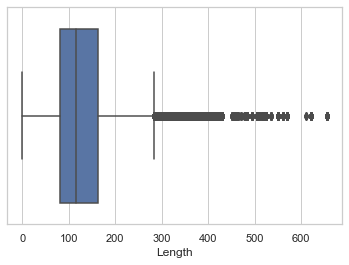

In [10]:
sns.boxplot('Length', data=df)
plt.show()

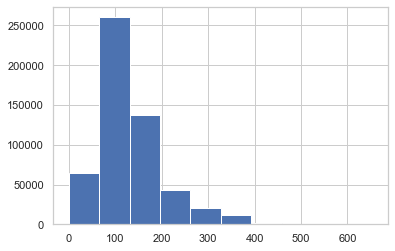

In [11]:
# Create a histogram to detect outliers.
plt.hist(df['Length'], bins=10)
plt.show()

#### Since we will predict delay, the outliers in the length appear reasonable, which we will keep.

In [12]:
df.groupby('Delay').mean()

,Flight,DayOfWeek,Time,Length
Delay,,,,
0,2513.485713,3.974625,765.236708,129.657594
1,2321.413508,3.873697,849.405308,135.369697


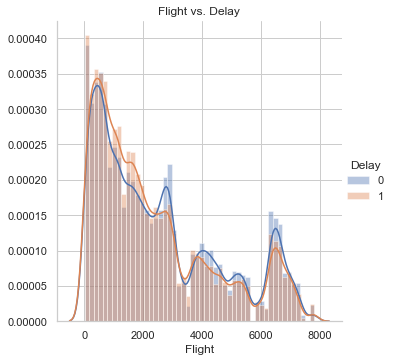

In [13]:
sns.FacetGrid(df, hue='Delay', height=5).map(sns.distplot, 'Flight').add_legend().set(title='Flight vs. Delay')
plt.show()

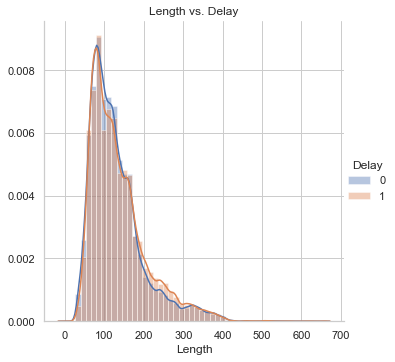

In [14]:
sns.FacetGrid(df, hue='Delay', height=5).map(sns.distplot, 'Length').add_legend().set(title='Length vs. Delay')
plt.show()

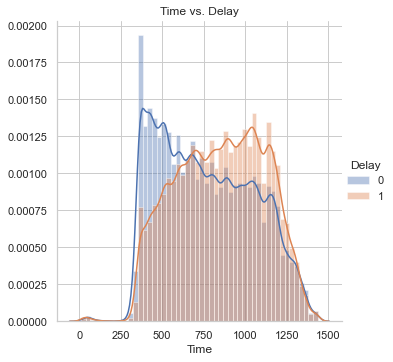

In [15]:
sns.FacetGrid(df, hue='Delay', height=5).map(sns.distplot, 'Time').add_legend().set(title='Time vs. Delay')
plt.show()

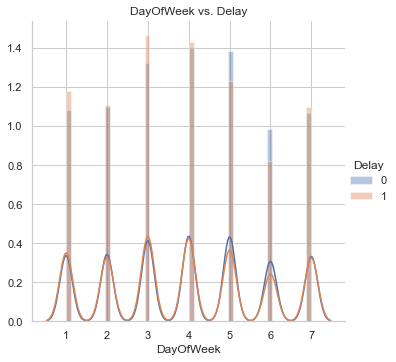

In [16]:
sns.FacetGrid(df, hue='Delay', height=5).map(sns.distplot, 'DayOfWeek').add_legend().set(title='DayOfWeek vs. Delay')
plt.show()

### Analyze for categorical variables.

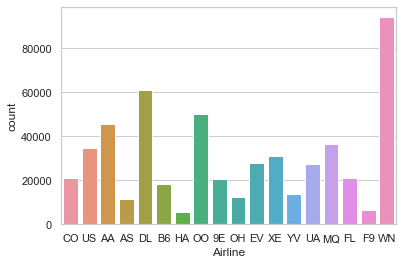

In [17]:
sns.countplot('Airline', data=df)
plt.show()

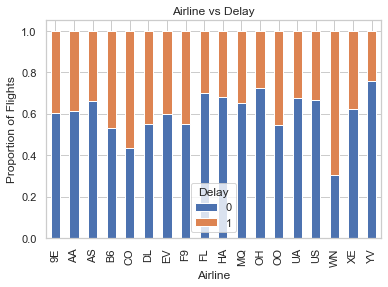

In [18]:
table = pd.crosstab(df.Airline,df.Delay)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

plt.title('Airline vs Delay')
plt.xlabel('Airline')
plt.ylabel('Proportion of Flights')
plt.show()

In [19]:
# Unique from-Airports.
fa = df.AirportFrom.unique()
fa

array(['SFO', 'PHX', 'LAX', 'ANC', 'LAS', 'SLC', 'DEN', 'ONT', 'FAI',
       'BQN', 'PSE', 'HNL', 'BIS', 'IYK', 'EWR', 'BOS', 'MKE', 'GFK',
       'OMA', 'GSO', 'LMT', 'SEA', 'MCO', 'TPA', 'DLH', 'MSP', 'FAR',
       'MFE', 'MSY', 'VPS', 'BWI', 'MAF', 'LWS', 'RST', 'ALB', 'DSM',
       'CHS', 'MSN', 'JAX', 'SAT', 'PNS', 'BHM', 'LIT', 'SAV', 'BNA',
       'ICT', 'ECP', 'DHN', 'MGM', 'CAE', 'PWM', 'ACV', 'EKO', 'PHL',
       'ATL', 'PDX', 'RIC', 'BTR', 'HRL', 'MYR', 'TUS', 'SBN', 'CAK',
       'TVC', 'CLE', 'ORD', 'DAY', 'MFR', 'BTV', 'TLH', 'TYS', 'DFW',
       'FLL', 'AUS', 'CHA', 'CMH', 'LRD', 'BRO', 'CRP', 'LAN', 'PVD',
       'FWA', 'JFK', 'LGA', 'OKC', 'PIT', 'PBI', 'ORF', 'DCA', 'AEX',
       'SYR', 'SHV', 'VLD', 'BDL', 'FAT', 'BZN', 'RDM', 'LFT', 'IPL',
       'EAU', 'ERI', 'BUF', 'IAH', 'MCI', 'AGS', 'ABI', 'GRR', 'LBB',
       'CLT', 'LEX', 'MBS', 'MOD', 'AMA', 'SGF', 'AZO', 'ABE', 'SWF',
       'BGM', 'AVP', 'FNT', 'GSP', 'ATW', 'ITH', 'TUL', 'COS', 'ELP',
       'ABQ', 'SMF',

In [20]:
# Number of Airport from.
len(fa)

293

In [21]:
# Unique to-Airports.
ta = df.AirportTo.unique()
ta

array(['IAH', 'CLT', 'DFW', 'SEA', 'MSP', 'DTW', 'ORD', 'ATL', 'PDX',
       'JFK', 'SLC', 'HNL', 'PHX', 'MCO', 'OGG', 'LAX', 'KOA', 'ITO',
       'SFO', 'MIA', 'IAD', 'SMF', 'PHL', 'LIH', 'DEN', 'LGA', 'MEM',
       'CVG', 'YUM', 'CWA', 'MKE', 'BQN', 'FAI', 'LAS', 'ANC', 'BOS',
       'LGB', 'FLL', 'SJU', 'EWR', 'DCA', 'BWI', 'RDU', 'MCI', 'TYS',
       'SAN', 'ONT', 'OAK', 'MDW', 'BNA', 'DAL', 'CLE', 'JAX', 'JNU',
       'RNO', 'ELP', 'SAT', 'OTZ', 'MBS', 'BDL', 'STL', 'HOU', 'AUS',
       'SNA', 'SJC', 'LIT', 'TUS', 'TUL', 'CMH', 'LAN', 'IND', 'AMA',
       'CRP', 'PIT', 'RKS', 'FWA', 'TPA', 'PBI', 'JAN', 'DSM', 'ADQ',
       'GRB', 'PVD', 'ABQ', 'SDF', 'RSW', 'MSY', 'BUR', 'BOI', 'TLH',
       'BHM', 'ACV', 'ORF', 'BET', 'KTN', 'RIC', 'SRQ', 'BTR', 'XNA',
       'MHT', 'GRR', 'SBN', 'SBA', 'ROA', 'CID', 'GPT', 'MFR', 'SGU',
       'HPN', 'OMA', 'OTH', 'GSP', 'LMT', 'BUF', 'MSN', 'BFL', 'CAE',
       'HRL', 'OKC', 'SYR', 'COS', 'BTV', 'CDC', 'SCC', 'DAY', 'SJT',
       'TVC', 'ROC',

In [22]:
# Number of Airport to.
len(ta)

293

### Categorcial variable encoding

In [23]:
ord_enc = OrdinalEncoder()

df["Airport_From"] = ord_enc.fit_transform(df[["AirportFrom"]])
df["Airport_To"] = ord_enc.fit_transform(df[["AirportTo"]])
df["Airlines"] = ord_enc.fit_transform(df[["Airline"]])

df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Airport_From,Airport_To,Airlines
0,CO,269,SFO,IAH,3,15,205,1,253.0,135.0,4.0
1,US,1558,PHX,CLT,3,15,222,1,217.0,60.0,14.0
2,AA,2400,LAX,DFW,3,20,165,1,154.0,80.0,1.0
3,AA,2466,SFO,DFW,3,20,195,1,253.0,80.0,1.0
4,AS,108,ANC,SEA,3,30,202,0,14.0,252.0,2.0


In [24]:
# Prepared dataset.
n_df = df.drop(columns=['Airline', 'AirportFrom', 'AirportTo'], axis=1)
n_df.head()

,Flight,DayOfWeek,Time,Length,Delay,Airport_From,Airport_To,Airlines
0,269,3,15,205,1,253.0,135.0,4.0
1,1558,3,15,222,1,217.0,60.0,14.0
2,2400,3,20,165,1,154.0,80.0,1.0
3,2466,3,20,195,1,253.0,80.0,1.0
4,108,3,30,202,0,14.0,252.0,2.0


In [25]:
# Specify x and y
x = n_df.drop('Delay', axis=1)
y = n_df.Delay

# Scale the data.
X = StandardScaler().fit_transform(x)

In [26]:
# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

#### Since the data set is large, knn model is not recommend.

### 1. Decision Tree Classifier

In [27]:
start = time.time()

dt = DecisionTreeClassifier(max_depth=3, random_state=20)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=20)

In [28]:
end = time.time()
print('dt runtime: ', end - start)

dt runtime:  0.9231359958648682


In [29]:
dt.score(X_train, y_train)

0.6231593535199974

In [30]:
# Accuracy score.
dt.score(X_test, y_test)

0.6251471583377365

In [31]:
y_pred = dt.predict(X_test)

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Classification Report.
cr = classification_report(y_test, y_pred)

print(f'Confusion Matrix\n {cm}\n\nClassification Report\n{cr}')

Confusion Matrix
 [[54182  5642]
 [34796 13257]]

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.91      0.73     59824
           1       0.70      0.28      0.40     48053

    accuracy                           0.63    107877
   macro avg       0.66      0.59      0.56    107877
weighted avg       0.65      0.63      0.58    107877



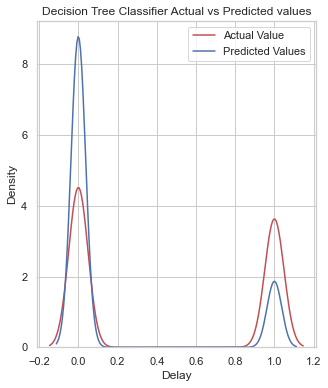

In [32]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Decision Tree Classifier Actual vs Predicted values')
plt.legend()
plt.show()

In [33]:
# Area under ROC curve
y_prob = dt.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_prob)

0.654038483542457

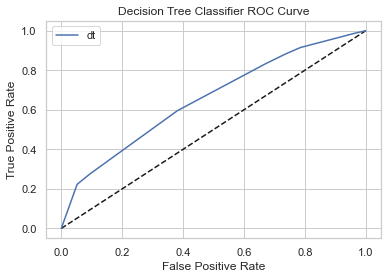

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='dt')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Decision Tree Classifier ROC Curve')
plt.legend()
plt.show()

### 2. Random Forest Classifier

In [35]:
start = time.time()

rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=0.1, random_state=20)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=0.1, n_estimators=400, random_state=20)

In [36]:
end = time.time()
print('rf runtime: ', end - start)

rf runtime:  103.186527967453


In [37]:
rf.score(X_train, y_train)

0.611553489406868

In [38]:
rf.score(X_test, y_test)

0.6133281422360651

In [39]:
y_pred = rf.predict(X_test)

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Classification Report.
cr = classification_report(y_test, y_pred)

print(f'Confusion Matrix\n {cm}\n\nClassification Report\n{cr}')

Confusion Matrix
 [[53103  6721]
 [34992 13061]]

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.89      0.72     59824
           1       0.66      0.27      0.39     48053

    accuracy                           0.61    107877
   macro avg       0.63      0.58      0.55    107877
weighted avg       0.63      0.61      0.57    107877



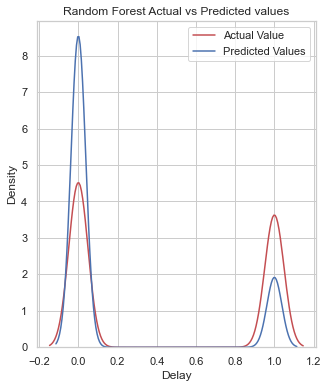

In [40]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Random Forest Actual vs Predicted values')
plt.legend()
plt.show()

In [41]:
# Area under ROC curve
y_prob = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_prob)

0.6418266132142572

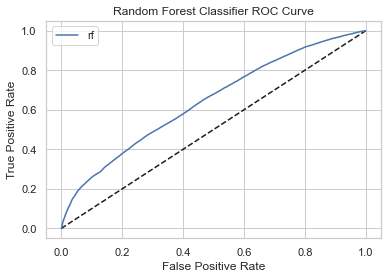

In [42]:
# Area under ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='rf')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Random Forest Classifier ROC Curve')
plt.legend()
plt.show()

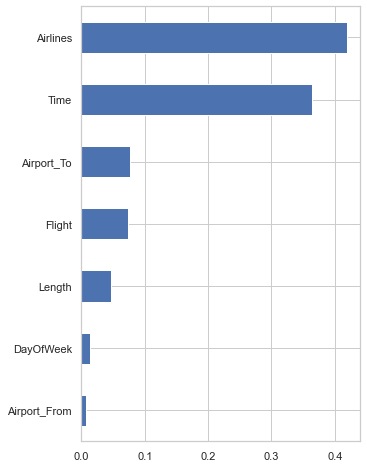

In [43]:
# Analyze Feature Importance.
im_rf = pd.Series(rf.feature_importances_, index=x.columns)

sort_im = im_rf.sort_values()
plt.figure(figsize=(5,8))
sort_im.plot(kind='barh')
plt.show()

#### Since the accuracy is low, this might due to overfitting. 
#### I would drop the last 3 attributes which contain the least feature importance.

In [44]:
x = x.drop(columns=['Length', 'DayOfWeek', 'Airport_From'], axis=1)
X = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

In [69]:
x.head()

,Flight,Time,Airport_To,Airlines
0,269,15,135.0,4.0
1,1558,15,60.0,14.0
2,2400,20,80.0,1.0
3,2466,20,80.0,1.0
4,108,30,252.0,2.0


### 3. Voting Classifier

In [45]:
start = time.time()

lr = LogisticRegression(random_state=20)
rf = RandomForestClassifier(random_state=20)
dt = DecisionTreeClassifier(random_state=20)

classifiers = [('Logistic Regression', lr),('Random Forest', rf),('Classification Tree', dt)]

vc = VotingClassifier(estimators=classifiers, voting='soft')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(random_state=20)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=20)),
                             ('Classification Tree',
                              DecisionTreeClassifier(random_state=20))],
                 voting='soft')

In [46]:
end = time.time()
print('vc runtime: ', end - start)

vc runtime:  98.0989899635315


In [47]:
vc.score(X_train, y_train)

0.7255009200335569

In [48]:
vc.score(X_test, y_test)

0.6634407705071517

In [49]:
y_pred = vc.predict(X_test)

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Classification Report.
cr = classification_report(y_test, y_pred)

print(f'Confusion Matrix\n {cm}\n\nClassification Report\n{cr}')

Confusion Matrix
 [[46196 13628]
 [22679 25374]]

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.77      0.72     59824
           1       0.65      0.53      0.58     48053

    accuracy                           0.66    107877
   macro avg       0.66      0.65      0.65    107877
weighted avg       0.66      0.66      0.66    107877



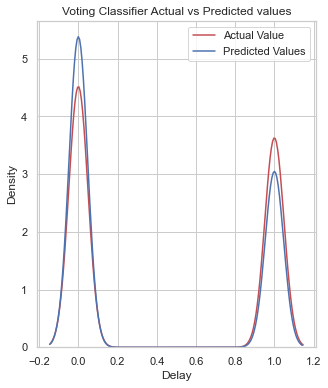

In [50]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Voting Classifier Actual vs Predicted values')
plt.legend()
plt.show()

In [51]:
# Area under ROC curve.
y_prob = vc.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_prob)

0.7098616250451307

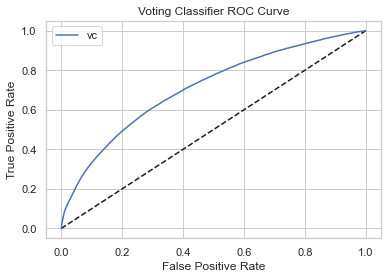

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='vc')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Voting Classifier ROC Curve')
plt.legend()
plt.show()

### 4. Decision Tree with Randomized Search CV 

In [53]:
start = time.time()

grid = {'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [0.04, 0.06, 0.08], 'max_features': [0.2, 0.4, 0.6, 0.8]}
dt = DecisionTreeClassifier(random_state=20)
dt_cv = RandomizedSearchCV(dt, grid, cv=5, n_jobs=-1)
dt_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=20),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6],
                                        'max_features': [0.2, 0.4, 0.6, 0.8],
                                        'min_samples_leaf': [0.04, 0.06, 0.08]})

In [54]:
end = time.time()
print('dt_cv runtime: ', end - start)

dt_cv runtime:  17.95108675956726


In [55]:
dt_cv.score(X_train, y_train)

0.6307930828308297

In [56]:
dt_cv.score(X_test, y_test)

0.6307646671672368

In [57]:
y_pred = dt_cv.predict(X_test)

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Classification Report.
cr = classification_report(y_test, y_pred)

print(f'Confusion Matrix\n {cm}\n\nClassification Report\n{cr}')

Confusion Matrix
 [[48628 11196]
 [28636 19417]]

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.81      0.71     59824
           1       0.63      0.40      0.49     48053

    accuracy                           0.63    107877
   macro avg       0.63      0.61      0.60    107877
weighted avg       0.63      0.63      0.61    107877



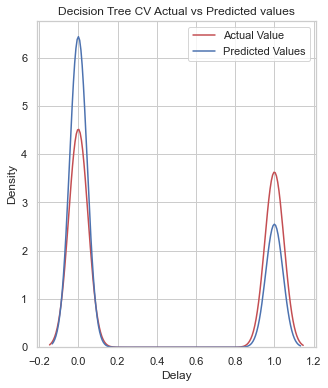

In [58]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Decision Tree CV Actual vs Predicted values')
plt.legend()
plt.show()

In [59]:
# Area under ROC curve
y_prob = dt_cv.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_prob)

0.6594580974592182

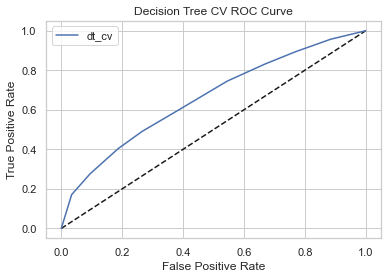

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='dt_cv')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Decision Tree CV ROC Curve')
plt.legend()
plt.show()

### 5. Ada Boost

In [61]:
start = time.time()

dt = DecisionTreeClassifier(max_depth=3, random_state=20)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=200)
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=20),
                   n_estimators=200)

In [62]:
end = time.time()
print('ada runtime: ', end - start)

ada runtime:  153.40957188606262


In [63]:
# Training accuracy.
ada.score(X_train, y_train)

0.6540697000736954

In [64]:
# Testing accuracy.
ada.score(X_test, y_test)

0.6482568109977104

#### The accuracy improved, but it took much longer to run the model.
#### The model is not overfitted.

In [65]:
y_pred = ada.predict(X_test)

# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Classification Report.
cr = classification_report(y_test, y_pred)

print(f'Confusion Matrix\n {cm}\n\nClassification Report\n{cr}')

Confusion Matrix
 [[47446 12378]
 [25567 22486]]

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.79      0.71     59824
           1       0.64      0.47      0.54     48053

    accuracy                           0.65    107877
   macro avg       0.65      0.63      0.63    107877
weighted avg       0.65      0.65      0.64    107877



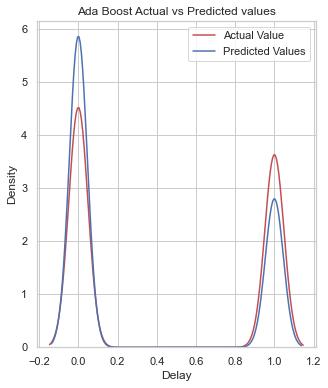

In [66]:
# Actual vs. Predicted Value.
plt.figure(figsize=(5, 6))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values", ax=ax)

plt.title('Ada Boost Actual vs Predicted values')
plt.legend()
plt.show()

In [67]:
# Area under ROC curve
y_prob = ada.predict_proba(X_test)[:, 1]
roc_auc_score(y_test,y_prob)

0.6937984973042297

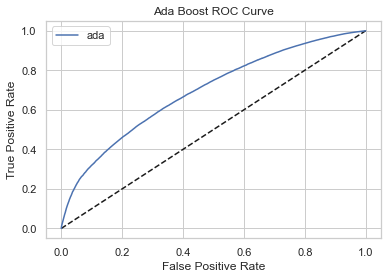

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='ada')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Ada Boost ROC Curve')
plt.legend()
plt.show()